In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.font_manager
import seaborn as sns
from scipy import stats
from sklearn import datasets, decomposition, preprocessing, model_selection
from sklearn.model_selection import train_test_split

# Import models
from keras import models, layers, activations, losses, optimizers, metrics
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras_visualizer import visualizer

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# Read data and filter necessary columns
dt = pd.read_csv("data.csv")
dt = dt.iloc[:,[10, 2, 3, 19]]
dt.sort_values(["session_user_id", "log_dtimes"], ascending = (True, True))

dt.head(n = 15)

,session_user_id,log_dtimes,log_desc,anomaly_class
0,aaron.johnson@yahoo.com,2021-09-03 07:46:47.369385,Otp send sucessfully,normal
1,aaron.johnson@yahoo.com,2021-09-03 07:46:55.842752,User sucessfully logged-in,normal
2,aaron.johnson@yahoo.com,2021-09-03 07:46:56.029170,Retrieve All Pre-Registration data failed,normal
3,aaron.johnson@yahoo.com,2021-09-03 07:47:48.506340,Pre-Registration data is sucessfully saved in ...,normal
4,aaron.johnson@yahoo.com,2021-09-03 07:47:49.026525,No documents found for the application,normal
5,aaron.johnson@yahoo.com,2021-09-03 07:47:49.035163,"Retrieve All Pre-Registration id, Full name, S...",normal
6,aaron.johnson@yahoo.com,2021-09-03 07:48:09.057271,Document uploaded & the respective Pre-Registr...,normal
7,aaron.johnson@yahoo.com,2021-09-03 07:48:10.805963,Retrieval of document is successfull,normal
8,aaron.johnson@yahoo.com,2021-09-03 07:48:27.861973,Availability retrieved successfully for booking,normal
9,aaron.johnson@yahoo.com,2021-09-03 07:48:55.132138,Appointment booked successfully,normal


In [3]:
# Handle data types and derive inter-event times
categ_order = ['Otp send sucessfully', 
               'User sucessfully logged-in', 
               'Pre-Registration data is sucessfully saved in the demographic table',
               'Document uploaded & the respective Pre-Registration data is saved in the document table',
               'Availability retrieved successfully for booking',
               'Appointment booked successfully']
cat_type = CategoricalDtype(categories=categ_order, ordered=True)
dt.log_desc = dt.log_desc.astype(cat_type)
dt.log_desc = dt.log_desc.cat.codes
dt = dt[dt.log_desc > -1].reset_index(drop=True)

dt.session_user_id = dt.session_user_id.astype('string')
dt['log_dtimes'] = pd.to_datetime(dt['log_dtimes'])

dt['delta'] = dt.groupby('session_user_id')['log_dtimes'].diff()
dt.delta = dt.delta.dt.total_seconds().fillna(0.0)

dt.head(n = 10)

,session_user_id,log_dtimes,log_desc,anomaly_class,delta
0,aaron.johnson@yahoo.com,2021-09-03 07:46:47.369385,0,normal,0.000000
1,aaron.johnson@yahoo.com,2021-09-03 07:46:55.842752,1,normal,8.473367
2,aaron.johnson@yahoo.com,2021-09-03 07:47:48.506340,2,normal,52.663588
3,aaron.johnson@yahoo.com,2021-09-03 07:48:09.057271,3,normal,20.550931
4,aaron.johnson@yahoo.com,2021-09-03 07:48:27.861973,4,normal,18.804702
5,aaron.johnson@yahoo.com,2021-09-03 07:48:55.132138,5,normal,27.270165
6,aaron.long@gmail.com,2021-09-04 14:44:27.223021,0,normal,0.000000
7,aaron.long@gmail.com,2021-09-04 14:44:35.975342,1,normal,8.752321
8,aaron.long@gmail.com,2021-09-04 14:45:28.158174,2,normal,52.182832
9,aaron.long@gmail.com,2021-09-04 14:45:48.687457,3,normal,20.529283


In [4]:
# Create one record per session
dt_cast = dt.pivot_table(index=["session_user_id", "anomaly_class"], 
                    columns='log_desc', 
                    values='delta').reset_index()
dt_cast.columns = ['id', 'anomaly_class', 'delta_0', 'delta_1', 'delta_2', 'delta_3', 
                   'delta_4', 'delta_5']

anomaly_labels = dt_cast.anomaly_class
dt_cast = dt_cast.drop(['id','anomaly_class', 'delta_0'], 1)

dt_cast.head()

,delta_1,delta_2,delta_3,delta_4,delta_5
0,8.473367,52.663588,20.550931,18.804702,27.270165
1,8.752321,52.182832,20.529283,19.612526,27.770277
2,0.487571,12.240277,1.676799,2.603957,3.160149
3,0.485956,12.524067,1.365008,2.235083,3.068871
4,0.517354,12.402699,2.004879,2.723665,2.654119


In [5]:
# scale features
scaler = preprocessing.StandardScaler()
scaled_features = scaler.fit_transform(dt_cast.values)
df_scaled = pd.DataFrame(scaled_features, index=dt_cast.index, columns=dt_cast.columns)
df_scaled['anomaly_class'] = anomaly_labels
df_scaled['is_anomaly'] = 0
df_scaled.loc[df_scaled['anomaly_class'] == 'anomalous', 'is_anomaly'] = 1
df_scaled = df_scaled.drop(['anomaly_class'], 1)

df_scaled.head()

,delta_1,delta_2,delta_3,delta_4,delta_5,is_anomaly
0,1.215031,0.986628,0.919577,0.945015,0.906070,0
1,1.292823,0.962749,0.917379,1.040844,0.944969,0
2,-1.011968,-1.021129,-0.996877,-0.976829,-0.969228,1
3,-1.012418,-1.007033,-1.028535,-1.020587,-0.976328,1
4,-1.003662,-1.013061,-0.963564,-0.962628,-1.008588,1


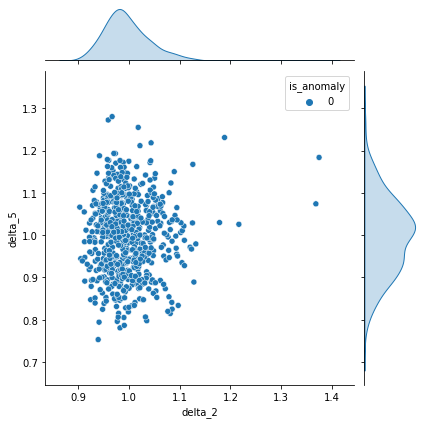

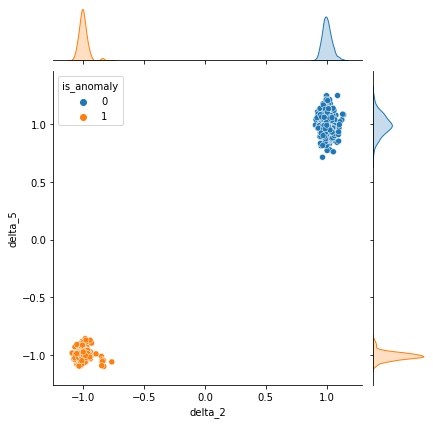

In [6]:
# Prepare train data with ony normal events and test data with all events
train_data, test_data = train_test_split(df_scaled, train_size=0.67, random_state = 42)
train_data_normals = train_data[train_data.is_anomaly == 0]

# Scatter plot of 2 features
sns.jointplot(data = train_data_normals, x="delta_2", y="delta_5", hue = "is_anomaly", kind='scatter')
sns.jointplot(data = test_data, x="delta_2", y="delta_5", hue = "is_anomaly", kind='scatter')

train_data_normals = train_data_normals.drop(['is_anomaly'], 1)
test_data_without_labels = test_data.drop(['is_anomaly'], 1)

In [7]:
n_features = 5
n_bottleneck = 2
model = models.Sequential([  
    layers.Dense(units=n_bottleneck, activation='relu', input_shape=(n_features,)),
    layers.Dense(units=n_features, activation='sigmoid')])  
  
visualizer(model, format='png', view=True)

In [8]:
# model
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=n_bottleneck, activation=activations.relu, input_shape=(n_features,)))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=n_features, activation=activations.sigmoid, input_shape=(n_bottleneck,)))

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(
	loss=losses.mean_squared_error,
	optimizer=optimizers.Adam(),
	metrics=[metrics.mean_squared_error])

print(autoencoder.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 2)                 12        
_________________________________________________________________
decoder (Sequential)         (None, 5)                 15        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/100
33/33 [==============================] - 1s 5ms/step - loss: 1.2460 - mean_squared_error: 1.2460 - val_loss: 1.2242 - val_mean_squared_error: 1.2242
Epoch 2/100
33/33 [==============================] - 0s 1ms/step - loss: 1.2269 - mean_squared_error: 1.2269 - val_loss: 1.2053 - val_mean_squared_error: 1.2053
Epoch 3/100
33/33 [==============================] - 0s 1ms/step - loss: 1.2087 - mean_squared_error: 1.2087 - val_loss: 1.1876 - val_mean_squared_error: 1.1876
Epoch 4/100
33/33 [==============================] - 0s 1ms/step - loss: 1.1912 - mean_squared_error: 1.1912 - val_loss: 1.1698 - val_mean_squared_error: 1.1698
Epoch 5/100
33/33 [==============================] - 0s 1ms/step - loss: 1.1730 - mean_squared_error: 1.1730 - val_loss: 1.1509 - val_mean_squared_error: 1.1509
Epoch 6/100
33/33 [==============================] - 0s 1ms/step - loss: 1.1537 - mean_squared_error: 1.1537 - val_loss: 1.1312 - val_mean_squared_error: 1.1312
Epoch 7/100
33/33 [===============

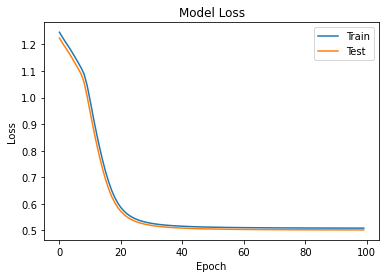

In [9]:
es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, restore_best_weights=True)
history = autoencoder.fit(x=train_data_normals, y=train_data_normals, epochs=100, batch_size=32,
                    shuffle=True, verbose=1, validation_split=0.2, callbacks=[es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

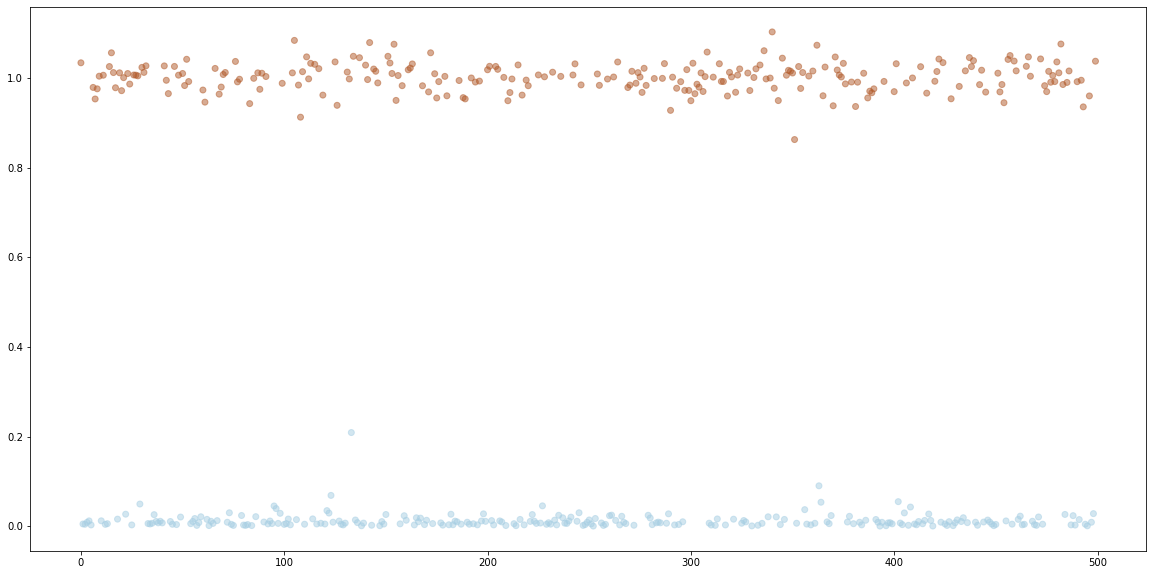

In [10]:
predicted_test = autoencoder.predict(x=test_data_without_labels)

test_mse = losses.mean_squared_error(test_data_without_labels, predicted_test)

plot_samples = 500

plt.rcParams['figure.figsize'] = [20, 10]
plt.scatter(range(plot_samples), test_mse[:plot_samples], 
            c = test_data.is_anomaly[:plot_samples], 
            cmap='Paired', alpha = 0.5)
plt.show()

In [11]:
# saving the dataframe
test_mse = pd.DataFrame({'truth': test_data.is_anomaly.values, 'mse': test_mse})
test_mse.to_csv('mse_file.csv', index=False)